**MSc Computational Physics AUTH**<br>
**Computational Tools**<br>
**Academic Year: 2023-2024**<br>
**Semester 1**<br>
**Implemented by: Ioannis Stergakis**<br>
**AEM: 4439**<br>

# **SET #2:** ***Estimating π using Monte Carlo simulation***
**Notebook 2**<br> 

**Contents:**<br>
*->1. Parallel programming implementation: compiling and running OpenMP C scripts*<br>
*for different number of total points and fixed number of threads at maximum physical threads*<br>
*->2. Convergence rate analysis codes*<br>
*->3. Results*

**Importing useful libraries**<br>

Before we begin our code implementation we import the necessary Python libraries.

In [1]:
import numpy as np 
import sympy as smp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd  
import time 
import subprocess
import re
import os 

## *1. OpenMP C scripts compilation and execution using the Python 'subprocess' module*

### **1.1 Defining a function to implement the compilation and execution of C scripts**

In [2]:
# Inputs

# num_threads: number of threads to be used
# total_points: list of (different) numbers of total random points to be generated at every Monte Carlo simulation

def pi_estimation_parallel_2(num_threads,total_points):
    # Initializing storage lists
    pi_est_vals = [] # list to store the pi estimations
    pi_error_vals = [] # list to store the errors in pi estimation (Python measured true percent relative errors)
    
    
    # C Script compilation

    # For Windows compilation use: ['gcc','pi_estimation_MC.c','-o','pi_estimation_MC','-fopenmp']
    # For Linux compilation use: ['g++','pi_estimation_MC.c','-o','pi_estimation_MC.exe','-fopenmp']
    # as the first argument in the subprocess.run() function
    compile_procedure = subprocess.run(['gcc', 'pi_estimation_MC.c', '-o', 'pi_estimation_MC', '-fopenmp'], capture_output=True, text=True, shell=True)

    # Checking for correct compilation
    if compile_procedure.returncode == 0: # successful compilation
        print(">Successful compilation!\n")
        print(">Running the .exe file!\n")
        
        # Initializing simulation counter index
        i = 1

        # Running the C executable for different number of threads
        for points in total_points:
            # Printing the queue number of the current
            print("\n\n>MONTE CARLO SIMULATION %d running....."%i)

            # Setting time meausurement (in the notebook) and running the compiled C executable using the current threads

            # For Windows execution use: ['pi_estimation_MC',f'{points}',f'{threads}']
            # For Linux execution use: ['./pi_estimation_MC',f'{points}',f'{threads}']
            # as the first argument in the subprocess.run() function
            start_time = time.time() # starting the execution time measurement 
            exe_procedure = subprocess.run(['pi_estimation_MC', f'{points}', f'{num_threads}'], capture_output=True, text=True, shell=True)
            end_time = time.time() # ending the execution time measurements

            # Obtain the output from the current execution
            exe_output = exe_procedure.stdout

            # Print the output of the current execution
            print(exe_output)

            # Print any error messages in the execution, if such are present
            if exe_procedure.stderr:
                print(">Error messages:\n", exe_procedure.stderr)

            # Using regular expression to exctract the pi estimation from the output
            pi_estimation_str = re.findall(r"Pi Estimation: (\d.+)", exe_output)
            pi_estimation_list = [float(pi_estimation) for pi_estimation in pi_estimation_str] # Convert the extracted string to float list
            pi_estimation = pi_estimation_list[0] # Obtain the value from the float list

            # Using regular expression to exctract the C measured execution time from the output
            cpu_time_C_str = re.findall(r"Execution Time: (\d.+) seconds", exe_output)
            cpu_time_C_list = [float(cpu_time_C) for cpu_time_C in cpu_time_C_str] # Convert the extracted string to float list
            cpu_time_C = cpu_time_C_list[0] # Obtain the value from the float list

            # Calculate the execution time measured in the Jupyter notebook
            cpu_time_Py =  end_time - start_time

            # Calculate the true percent relative error in pi estimation
            pi_error = 100*abs(np.pi-pi_estimation)/np.pi

            # Print the Jupyter measured info of the current simulation
            print(">>MC SIMULATION INFO (Jupyter notebook)")
            print("--------------------------------------")
            print("Execution time: %.10f seconds"%cpu_time_Py)
            print("--------------------------------------")

            # Appending values to the respective storage lists
            pi_est_vals.append(pi_estimation) 
            pi_error_vals.append(pi_error)
            # Increasing the count of the simulations by 1
            i = i + 1
    
    else: # failed compilation
        print(">Compilation failed:\n")
        print(compile_procedure.stderr)
            

    return [pi_est_vals,pi_error_vals]

### **1.2 Defining a function to insert data from a recorded Monte Carlo simulation session**

In [3]:
# Inputs

# filename: the name of the .csv file to be opened (for example "MC_Sim2_try1.csv")
# header_include: can either take the value 'None' when headers are not included in the .csv matrix
# or can take the value of an integer number

def pi_estimation_insert(filename,header_include):
    read_data = pd.read_csv(filename,header=header_include)
    return read_data

## *2. Convergence rate analysis*

### **2.1 General approach: finding the best exponent $b$ for the fitting curve $y=x^b$**

In [22]:
# Inputs

# total_points: list of (different) numbers of total random points that were generated at every Monte Carlo simulation
# pi_errors: list of the errors in pi's estimation, obtained from all simulations
# exp_list: list of (different) exponents for the fitting curves: y=x^exponent

def convergence_analysis_1(total_points,pi_errors, exp_list):
        
    # Plotting the Pi estimation errors versus number of total points
    plt.plot(total_points,pi_errors,'o',ms=5,label='Estimation Errors')
    
    # Plotting possible fitting curves (power law: y=x^b)
    x = np.linspace(total_points[0],total_points[-1],200)
    for exponent in exp_list:
        y = x**exponent
        plt.plot(x,y,'--',lw=1.5,label='y=x^(%.2f)'%exponent)
    
    # Adding title,labels and legend to the plot
    plt.title('Pi Estimation Errors vs Total Points')
    plt.xlabel('Total Points')
    plt.ylabel('True percent relative error et (%)')
    # Making a log-log plot since we need to investigate the existance of the law of power
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid()

### **2.2 Specific approach I: finding the best value of the factor $a$ of the fitting curve: $y=a*x^b$**

In [5]:
# Inputs

# total_points: list of (different) numbers of total random points that were generated at every Monte Carlo simulation
# pi_errors: list of the errors in pi's estimation, obtained from all simulations
# a_vals: list of (different) values for the factor a of the fitting curves: y=a*x^b
# b_val: value of the exponent b in the fitting curve: y=a*x^b

def convergence_analysis_2(total_points,pi_errors,a_vals,b_val):
        
    # Plotting the Pi estimation errors versus number of total points
    plt.plot(total_points,pi_errors,'o',ms=5,label='Estimation Errors')
    
    # Finding and plotting the best possible power law fitting curve

    # Refining the x space (total_points) with more points 
    n = 100 # points for the linspace command 
    total_points_fit = np.linspace(total_points[0],total_points[-1],n)

    # Defining a function with the general power law formula y=a*x^b
    def fit_function(a,b,x):
        return a*x**b
    
    # Plotting the fit_function for the different values of a
    m = len(a_vals)
    for i in range(0,m):
        pi_errors_fit = []
        for j in range(0,n):
            pi_errors_fit.append(fit_function(a_vals[i],b_val,total_points_fit[j]))
        plt.plot(total_points_fit,pi_errors_fit,'--',lw=1.5,label='y=%.2fx^(%.2f)'%(a_vals[i],b_val))
    
    # Adding title,labels and legend to the plot
    plt.title('Pi Estimation Errors vs Total Points')
    plt.xlabel('Total Points')
    plt.ylabel('True percent relative error et (%)')
    # Making a log-log plot since we need to investigate the existance of the law of power 
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid()

### **2.3 Specific approach II: making the diagnostic plot for selected fitting curves: $y=a*x^b$**

In [6]:
# Inputs

# total_points: list of (different) numbers of total random points that were generated at every Monte Carlo simulation
# pi_errors: list of the errors in pi's estimation, obtained from all simulations
# a_vals: list of values of factor a of the fitting curves: y=a*x^b
# b_val: value of the exponent b in the fitting curve: y=a*x^b

def convergence_analysis_3(total_points,pi_errors,a_vals,b_val):
    # Defining a function with the general power law formula y=a*x^b
    def fit_function(a,b,x):
        return a*x**b
    fig,ax1 = plt.subplots(1,1,figsize=(9,6))
    # Storaging the min and max predicted value for each combination for the bounds of the diagnostic plot
    predicted_min_values = []
    predicted_max_values = []

    # Making the diagnostic plot of the selected fitting curves: y=a*x^b
    for a in a_vals:
        # Calculating the predicted values and the residuals in prediction
        predicted_vals = [] # list to store predicted values of the errors in pi estimation
        prediction_residuals = [] # list to store the residuals in prediction
        n = len(pi_errors) # length of the pi_errors list
        for i in range(0,n):
            prediction = np.log10(fit_function(a,b_val,total_points[i]))
            predicted_vals.append(prediction)
            prediction_residuals.append(np.log10(pi_errors[i])-prediction)
        predicted_min_values.append(min(predicted_vals))
        predicted_max_values.append(max(predicted_vals))

        # Calculate the normalized residuals of the predictions
        prediction_norm_residuals = []
        residuals_std = np.std(prediction_residuals) # standard deviation of residuals
        for i in range(0,n):
            prediction_norm_residuals.append(prediction_residuals[i]/residuals_std)
                
        # Plotting the normalized residuals vs predicted values for the current fitting curve
        plt.plot(predicted_vals,prediction_norm_residuals,"o",label="a=%.2f,b=%.2f"%(a,b_val))

    # Plotting the upper bound of the 95% confidence interval of the standard normal distribution: Z_upper = 1.96
    plt.plot([min(predicted_min_values),max(predicted_max_values)],[1.96,1.96],'--',label="Upper Bound")

    # Plotting the lower bound of the 95% confidence interval of the standard normal distribution: Z_upper = -1.96
    plt.plot([min(predicted_min_values),max(predicted_max_values)],[-1.96,-1.96],'--',label="Lower Bound")    
    
    # Adding title,labels and legend to the plot
    plt.title('Diagnostic plot')
    plt.xlabel('Predicted log. errors in π estimation')
    plt.ylabel('Normalized residuals in prediction')
    plt.legend(bbox_to_anchor=(1.01, 1.), loc='upper left')
    plt.grid()

## *3. Results*

### **3.1 Presenting the convergence rate results from recorded Monte Carlo simulation sessions**

#### **3.1.1 First try to observe the estimation errors convergence rate**

CONVERGENCE SESSION 1 RESULTS



,Threads,Max Threads,Total Points,Pi Estimation,Error (%),Exe Time (C) [sec]
0,22,22,1.000000e+02,3.040000,3.233795,0.019
1,22,22,1.000000e+03,3.268000,4.023671,0.017
2,22,22,1.000000e+04,3.205200,2.024685,0.014
3,22,22,1.000000e+05,3.153760,0.387299,0.010
4,22,22,1.000000e+06,3.147044,0.173522,0.028
5,22,22,1.000000e+07,3.144202,0.083058,0.089
6,22,22,1.000000e+08,3.140943,0.020692,0.478
7,22,22,1.000000e+09,3.140803,0.025145,4.192
8,22,22,1.000000e+10,3.141361,0.007380,42.207
9,22,22,1.000000e+11,3.141392,0.006399,594.096


>Convergence analysis


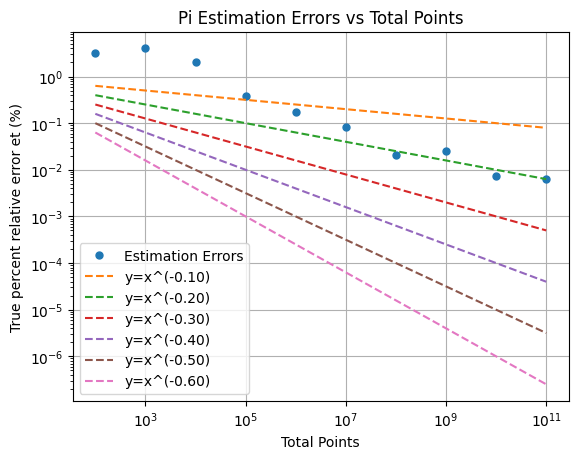

In [23]:
print("CONVERGENCE SESSION 1 RESULTS\n")

# Inserting and showing the data from the "MC_Sim2_try1.csv" file
MC_converg_1_data = pi_estimation_insert("MC_Sim2_try1.csv",0)
display(MC_converg_1_data)

# Execution time analysis

# Getting the number of total random generated points from the first convergence session
MC_converge_1_points_data = MC_converg_1_data.iloc[:,2]
n = len(MC_converge_1_points_data)
MC_converge_1_points = [] # storage list for the number of total points

# Getting the pi estimation errors from the first convergence session
MC_converge_1_errors_data = MC_converg_1_data.iloc[:,4]
MC_converge_1_errors = [] # storage list for the execution times (C measured)

# Appending the collected data to the respective storage lists (to ensure we get only the values)
for i in range(0,n):
    MC_converge_1_points.append(MC_converge_1_points_data[i])
    MC_converge_1_errors.append(MC_converge_1_errors_data[i])

print(">Convergence analysis")

# Using the convergence_analysis_1() function to get a general idea of the convergence rate
exponents_list = [-0.1,-0.2,-0.3,-0.4,-0.5,-0.6] # Arbirtary selection of the exponents in the expression y=x^b
convergence_analysis_1(MC_converge_1_points,MC_converge_1_errors,exponents_list)

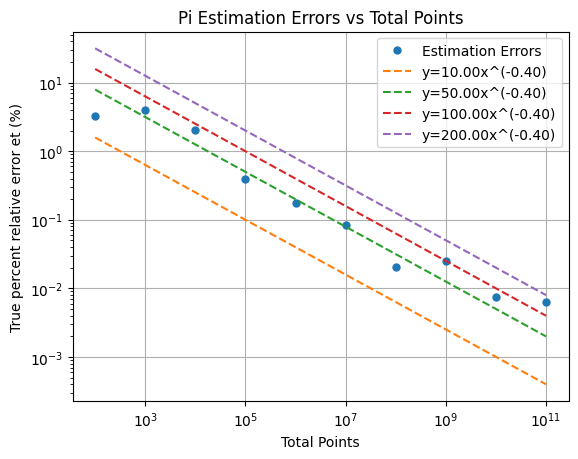

In [8]:
# From the diagram produced by the convergence_analysis_1() function
# we can see that the curves with exponent b = -0.4 and = -0.5, match best with the slope
# of the experimental (computational) errors data. Therefore we will
# investigate furtherly the expression y = a*x^b to get a satisfying value
# for the a coefficient.

# We will use the convergence_analysis_2() function, trying different values for the
# 'a' coefficient

# Try with b = -0.4
a = [10,50,100,200]
b = -0.4
convergence_analysis_2(MC_converge_1_points,MC_converge_1_errors,a,b)

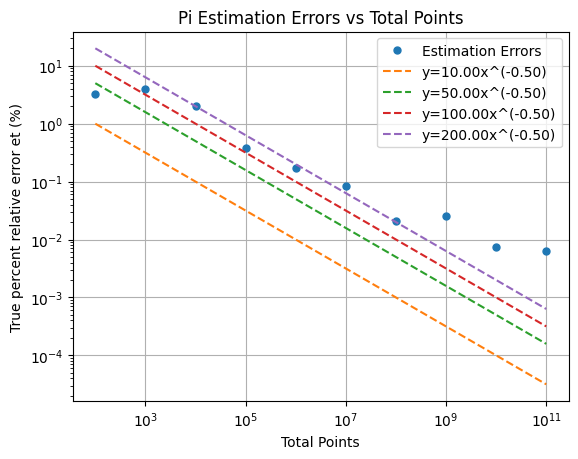

In [9]:
# Try with b = -0.5
a = [10,50,100,200]
b = -0.5
convergence_analysis_2(MC_converge_1_points,MC_converge_1_errors,a,b)
plt.savefig("Fig5_conv_analysis_2b.pdf",dpi=300)

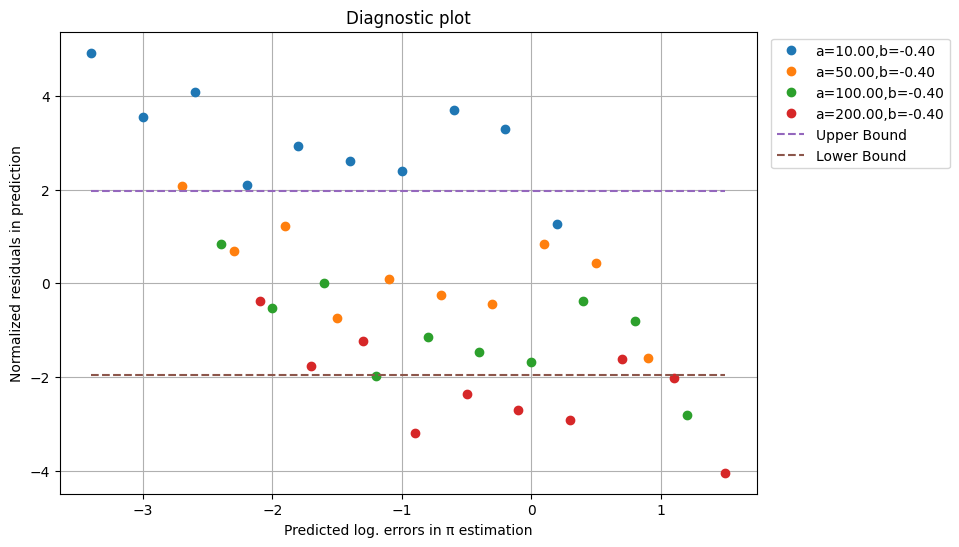

In [10]:
# As we can see from the last two figures, the best fitting results are obtained 
# for the following 2 combinations:
# a = 50 and b = -0.4
# a 200 and b = -0.5

# We can confirm this by making the diagnostic graphs of the respective fitting curves. 
# For that we use the function convergence_analysis_3() as shown below:

# Combinations with b = -0.4
a = [10,50,100,200]
b = -0.4
convergence_analysis_3(MC_converge_1_points,MC_converge_1_errors,a,b)

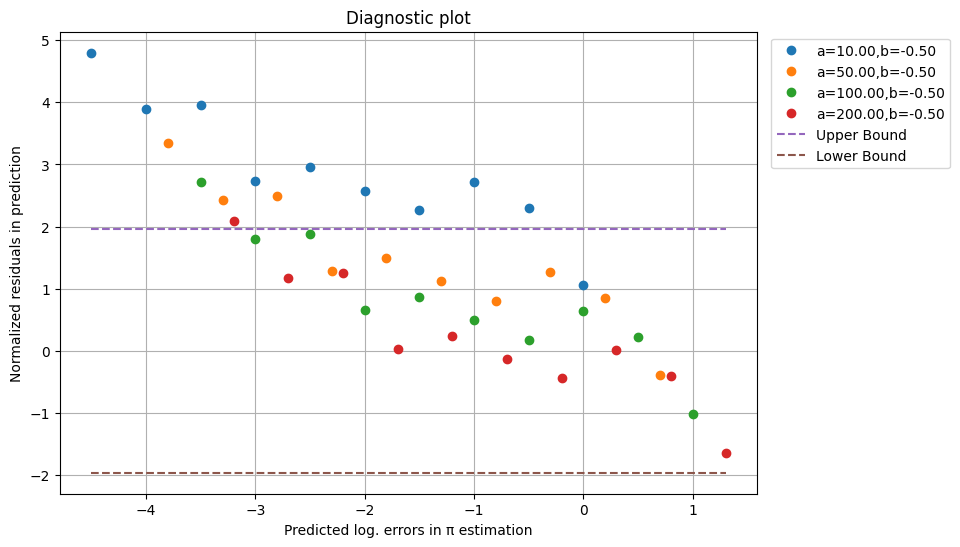

In [11]:
# Combinations with b = -0.5
a = [10,50,100,200]
b = -0.5
convergence_analysis_3(MC_converge_1_points,MC_converge_1_errors,a,b)

#### **3.1.2 Second try to observe the estimation errors convergence rate**

CONVERGENCE SESSION 2 RESULTS



,Threads,Max Threads,Total Points,Pi Estimation,Error (%),Exe Time (C) [sec]
0,22,22,1.000000e+02,3.000000,4.507034,0.018
1,22,22,1.000000e+03,3.260000,3.769023,0.021
2,22,22,1.000000e+04,3.197600,1.782769,0.020
3,22,22,1.000000e+05,3.153280,0.372020,0.013
4,22,22,1.000000e+06,3.146880,0.168301,0.021
5,22,22,1.000000e+07,3.144072,0.078907,0.081
6,22,22,1.000000e+08,3.140931,0.021060,0.464
7,22,22,1.000000e+09,3.140823,0.024501,4.290
8,22,22,1.000000e+10,3.141358,0.007465,43.260
9,22,22,1.000000e+11,3.141392,0.006387,631.936


>Convergence analysis


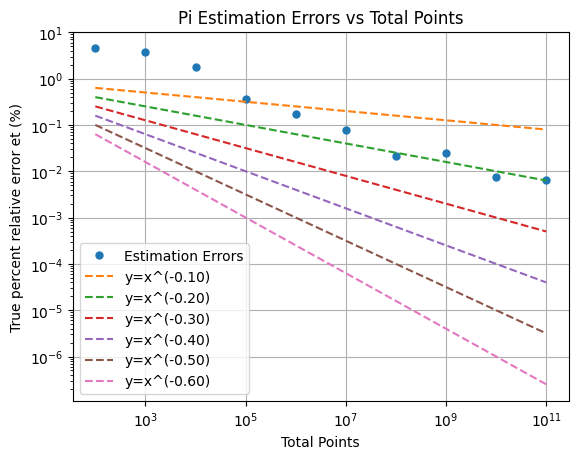

In [24]:
print("CONVERGENCE SESSION 2 RESULTS\n")

# Inserting and showing the data from the "MC_Sim2_try2.csv" file
MC_converg_2_data = pi_estimation_insert("MC_Sim2_try2.csv",0)
display(MC_converg_2_data)

# Execution time analysis

# Getting the number of total random generated points from the first convergence session
MC_converge_2_points_data = MC_converg_2_data.iloc[:,2]
n = len(MC_converge_2_points_data)
MC_converge_2_points = [] # storage list for the number of total points

# Getting the pi estimation errors from the first convergence session
MC_converge_2_errors_data = MC_converg_2_data.iloc[:,4]
MC_converge_2_errors = [] # storage list for the execution times (C measured)

# Appending the collected data to the respective storage lists (to ensure we get only the values)
for i in range(0,n):
    MC_converge_2_points.append(MC_converge_2_points_data[i])
    MC_converge_2_errors.append(MC_converge_2_errors_data[i])

print(">Convergence analysis")

# Using the convergence_analysis_1() function to get a general idea of the convergence rate
exponents_list = [-0.1,-0.2,-0.3,-0.4,-0.5,-0.6] # Arbirtary selection of the exponents in the expression y=x^b
convergence_analysis_1(MC_converge_2_points,MC_converge_2_errors,exponents_list)

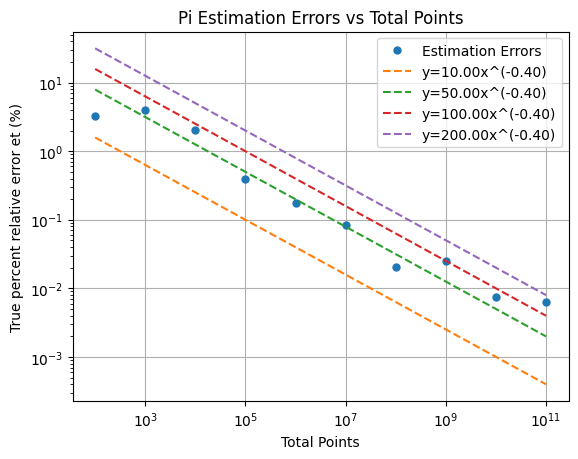

In [13]:
# From the diagram produced by the convergence_analysis_1() function
# we can see again that the curves with exponent b = -0.4 and = -0.5, match best with the slope
# of the experimental (computational) errors data. Therefore we will
# investigate furtherly the expression y = a*x^b to get a satisfying value
# for the a coefficient.

# We will use the convergence_analysis_2() function, trying different values for the
# 'a' coefficient

# Try with b = -0.4
a = [10,50,100,200]
b = -0.4
convergence_analysis_2(MC_converge_1_points,MC_converge_1_errors,a,b)

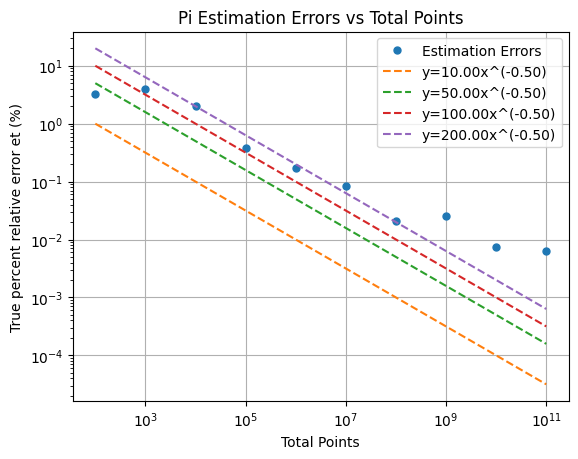

In [14]:
# Try with b = -0.5
a = [10,50,100,200]
b = -0.5
convergence_analysis_2(MC_converge_1_points,MC_converge_1_errors,a,b)

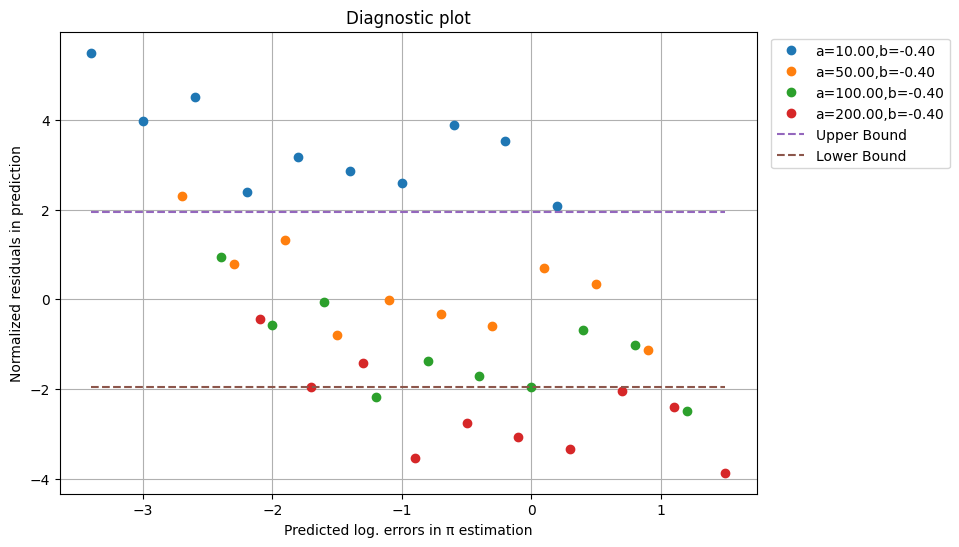

In [15]:
# As we can see from the last two figures, the best fitting results are obtained 
# for the following 2 combinations:
# a = 50 and b = -0.4
# a 200 and b = -0.5

# We can confirm this by making the diagnostic graphs of the respective fitting curves. 
# For that we use the function convergence_analysis_3() as shown below:

# Combinations with b = -0.4
a = [10,50,100,200]
b = -0.4
convergence_analysis_3(MC_converge_2_points,MC_converge_2_errors,a,b)

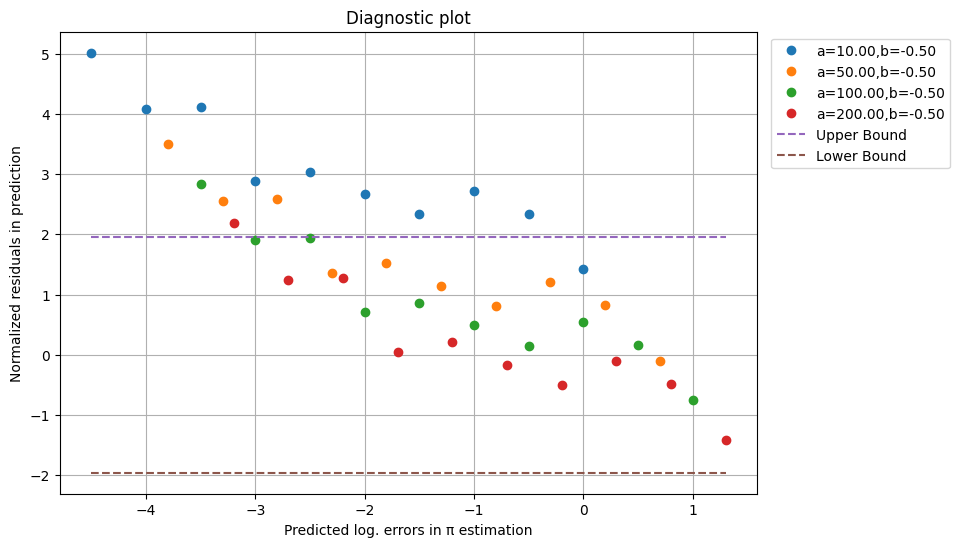

In [16]:
# Combinations with b = -0.5
a = [10,50,100,200]
b = -0.5
convergence_analysis_3(MC_converge_2_points,MC_converge_2_errors,a,b)

### **3.2 Presenting the convergence rate results from live Monte Carlo simulation session**

>Successful compilation!

>Running the .exe file!



>MONTE CARLO SIMULATION 1 running.....

>>MC SIMULATION INFO (C script):
--------------------------------------
Max Physical Threads: 22
Used Threads: 22
Total points: 100
--------------------------------------
Pi Estimation: 3.1200000000
True Percent Relative Error: 0.687316%
Execution Time: 0.0200000000 seconds
--------------------------------------

>>MC SIMULATION INFO (Jupyter notebook)
--------------------------------------
Execution time: 0.2708420753 seconds
--------------------------------------


>MONTE CARLO SIMULATION 2 running.....

>>MC SIMULATION INFO (C script):
--------------------------------------
Max Physical Threads: 22
Used Threads: 22
Total points: 1000
--------------------------------------
Pi Estimation: 3.2720000000
True Percent Relative Error: 4.150995%
Execution Time: 0.0220000000 seconds
--------------------------------------

>>MC SIMULATION INFO (Jupyter notebook)
--------------------------------------


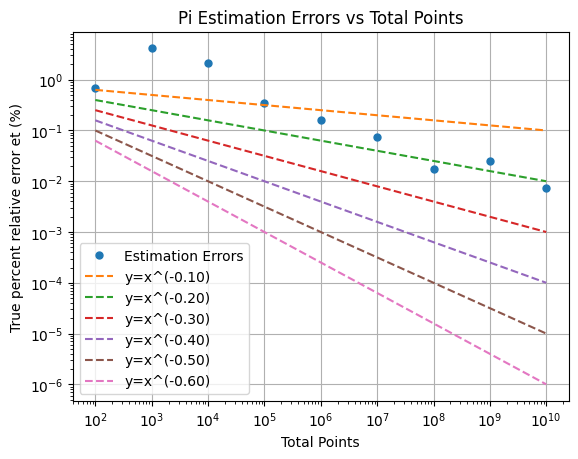

In [25]:
# Select a list containing different number of total points 

# In my case i have an Intel Core Ultra 9 185H processor with
# 6 performance cores (i.e. 2 threads per core) and
# 10 efficient cores (i.e. 1 thread per core ) resulting
# in a total of 22 physical threads, so i chose the values
# [10^2,10^3,10^4,10^5,10^6,10^7,10^8,10^9,10^10] for the total points

# As for the threads i chose the maximum number of physical threads (22)
# in order to get a short-timed Monte Carlo Parallel Session

# Of course the afformentioned choices can be changed depending on the hardware and its potential
# of one's PC, in order to get a short-timed Monte Carlo Parallel Session

# Defining the number of threads list
num_threads = 22

# Notice that if want to give ONLY ONE number of threads
# you have to declare also as a list, for the algorithm
# reads only iterable objects in the 'for' loop. For example
# if you want only 8 threads to be used you need to insert them as
# [8] in the "pi_estimation_parallel_1()" function

# Defining the total random points to be generated
total_points = [1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9,1e10]

# Running the "pi_estimation_parallel_1()" function for the selected 
# number of threads and points and get the results
[MC_live_estimations,MC_live_errors] = pi_estimation_parallel_2(num_threads,total_points)

# Presenting the results
print("LIVE SESSION RESULTS\n")

# Convergence rate analysis
print(">Convergence analysis")

# Using the convergence_analysis_1() function to get a general idea of the convergence rate
exponents_list = [-0.1,-0.2,-0.3,-0.4,-0.5,-0.6] # Arbirtary selection of the exponents in the expression y=x^b
convergence_analysis_1(total_points,MC_live_errors,exponents_list)

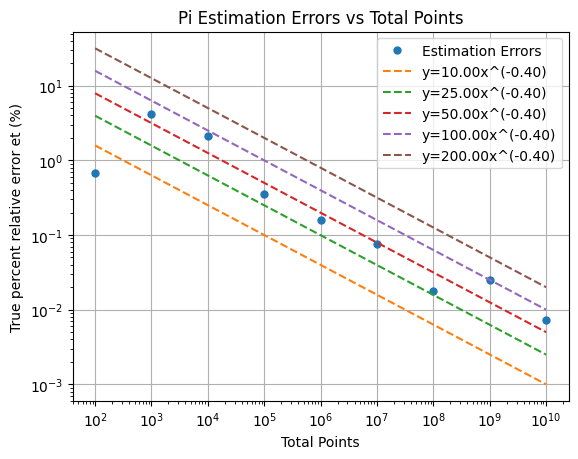

In [26]:
# From the diagram produced by the convergence_analysis_1() function
# we can see again that the curves with exponent b = -0.4 and = -0.5, match best with the slope
# of the experimental (computational) errors data. Therefore we will
# investigate furtherly the expression y = a*x^b to get a satisfying value
# for the a coefficient.

# We will use the convergence_analysis_2() function, trying different values for the
# 'a' coefficient

# Try with b = -0.4
a = [10,25,50,100,200]
b = -0.4
convergence_analysis_2(total_points,MC_live_errors,a,b)

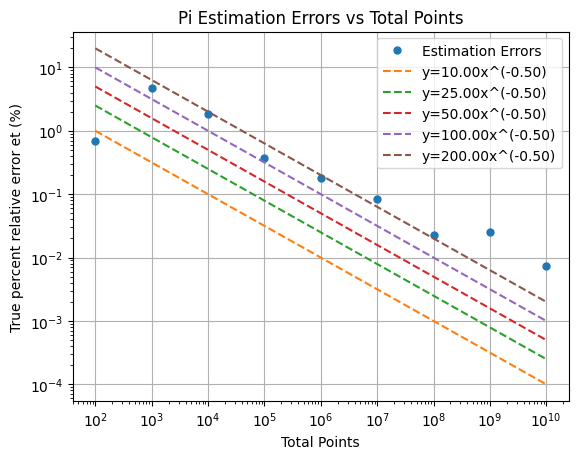

In [19]:
# Try with b = -0.5
a = [10,25,50,100,200]
b = -0.5
convergence_analysis_2(total_points,MC_live_errors,a,b)

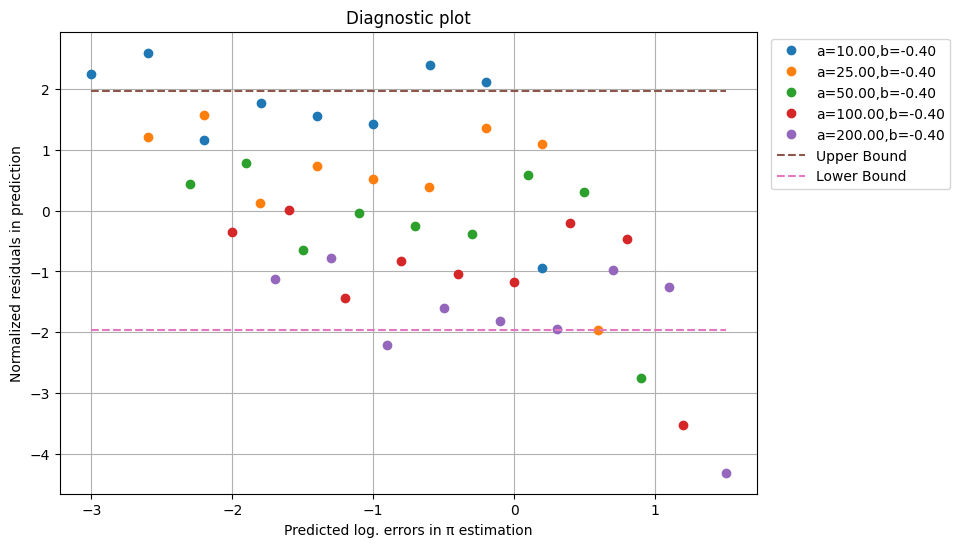

In [27]:
# To get a better image of the best combination for the 'a' and 'b' parameters
# we make the diagnostic plot of the fitting curves from the figure above
# using the convergence_analysis_3() function

# Combinations with b = -0.4
a = [10,25,50,100,200]
b = -0.4
convergence_analysis_3(total_points,MC_live_errors,a,b)

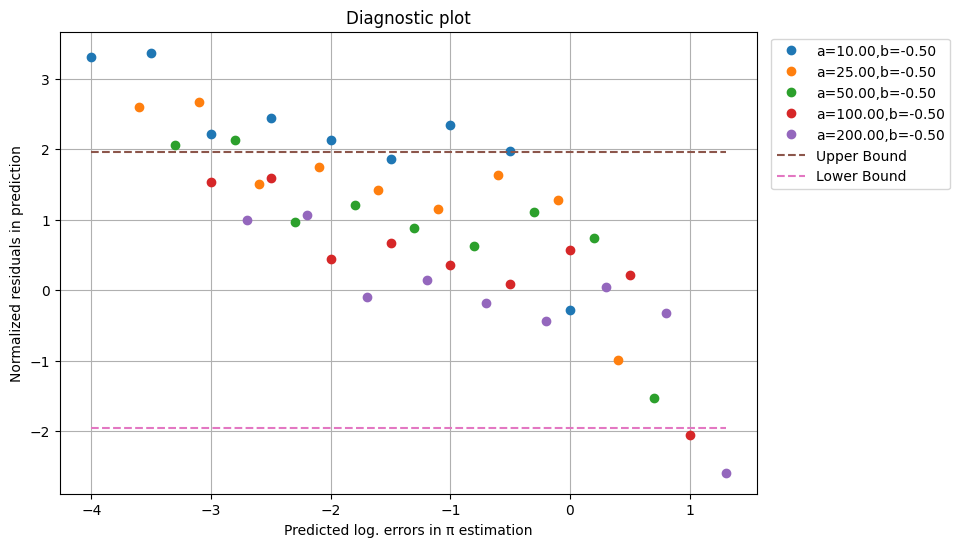

In [28]:
# Combinations with b = -0.5
a = [10,25,50,100,200]
b = -0.5
convergence_analysis_3(total_points,MC_live_errors,a,b)